# Speech Emotion Detection

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
import tensorflow as tf
from keras.src.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.src.utils import to_categorical

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

warnings.filterwarnings("ignore", category=DeprecationWarning)

### Data Preparation

In [5]:
CREMA = "datasets/CREMA-D/"
RAVDESS = "datasets/RAVDESS/"
SAVEE = "datasets/SAVEE"
TESS = "datasets/TESS/"

Creating a CREMA-D dataframe:

In [6]:
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []

for file in crema_directory_list:
    file_path.append(CREMA + file)
    part=file.split('_')
    
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
CREMA_df = pd.concat([emotion_df, path_df], axis=1)

CREMA_df.head()

Emotions                                  Path
0    angry  datasets/CREMA-D/1001_DFA_ANG_XX.wav
1  disgust  datasets/CREMA-D/1001_DFA_DIS_XX.wav
2     fear  datasets/CREMA-D/1001_DFA_FEA_XX.wav
3    happy  datasets/CREMA-D/1001_DFA_HAP_XX.wav
4  neutral  datasets/CREMA-D/1001_DFA_NEU_XX.wav

Creating a RAVDESS dataframe:

In [7]:
ravdess_directory_list = os.listdir(RAVDESS)

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor = os.listdir(RAVDESS + dir)

    for file in actor:
        part = file.split('.')[0].split('-')

        file_emotion.append(int(part[2]))  # The third part of the file name represents the emotion with which the actor is speaking
        file_path.append(RAVDESS + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
RAVDESS_df = pd.concat([emotion_df, path_df], axis=1)

RAVDESS_df["Emotions"].replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

RAVDESS_df.head()

Emotions                                               Path
0  neutral  datasets/RAVDESS/Actor_01/03-01-01-01-01-01-01...
1  neutral  datasets/RAVDESS/Actor_01/03-01-01-01-01-02-01...
2  neutral  datasets/RAVDESS/Actor_01/03-01-01-01-02-01-01...
3  neutral  datasets/RAVDESS/Actor_01/03-01-01-01-02-02-01...
4     calm  datasets/RAVDESS/Actor_01/03-01-02-01-01-01-01...

Creating a SAVEE dataframe:

In [8]:
savee_directory_list = os.listdir(SAVEE)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(SAVEE + file)
    part = file.split('_')[1]
    ele = part[:-6]

    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
SAVEE_df = pd.concat([emotion_df, path_df], axis=1)

SAVEE_df.head()

Emotions                      Path
0    angry  datasets/SAVEEDC_a01.wav
1    angry  datasets/SAVEEDC_a02.wav
2    angry  datasets/SAVEEDC_a03.wav
3    angry  datasets/SAVEEDC_a04.wav
4    angry  datasets/SAVEEDC_a05.wav

Creating a TESS dataframe:

In [9]:
tess_directory_list = os.listdir(TESS)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(TESS + dir)
    
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]

        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)

        file_path.append(TESS + dir + '/' + file)
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
TESS_df = pd.concat([emotion_df, path_df], axis=1)

TESS_df.head()

Emotions                                        Path
0    angry  datasets/TESS/OAF_angry/OAF_back_angry.wav
1    angry   datasets/TESS/OAF_angry/OAF_bar_angry.wav
2    angry  datasets/TESS/OAF_angry/OAF_base_angry.wav
3    angry  datasets/TESS/OAF_angry/OAF_bath_angry.wav
4    angry  datasets/TESS/OAF_angry/OAF_bean_angry.wav

Creating a main dataframe containing the above dataframes:

In [10]:
data_path = pd.concat([RAVDESS_df, TESS_df], axis=0)
data_path.to_csv("data_path.csv", index=False)

data_path.head()

Emotions                                               Path
0  neutral  datasets/RAVDESS/Actor_01/03-01-01-01-01-01-01...
1  neutral  datasets/RAVDESS/Actor_01/03-01-01-01-01-02-01...
2  neutral  datasets/RAVDESS/Actor_01/03-01-01-01-02-01-01...
3  neutral  datasets/RAVDESS/Actor_01/03-01-01-01-02-02-01...
4     calm  datasets/RAVDESS/Actor_01/03-01-02-01-01-01-01...

### Data Visualization

#### Count of Emotions

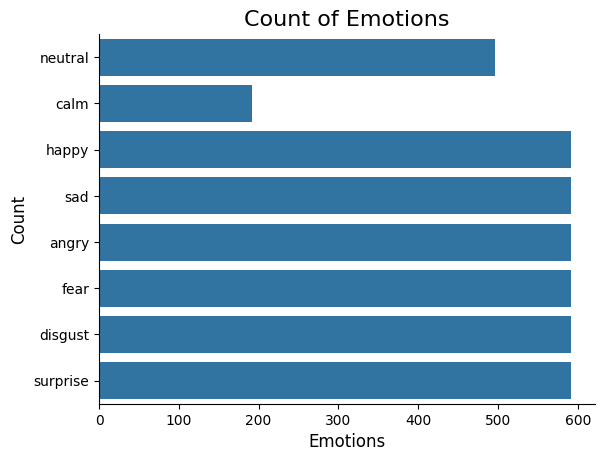

In [38]:
plt.title('Count of Emotions', size=16)

sns.countplot(data_path["Emotions"])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.show()

#### Creating Waveplots and Spectograms for Each Emotion

In [39]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    
    plt.show()


def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))

    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)

    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   

    plt.colorbar()

##### Fear

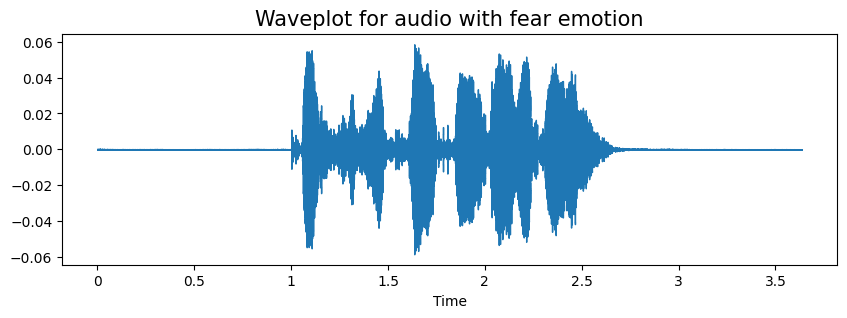

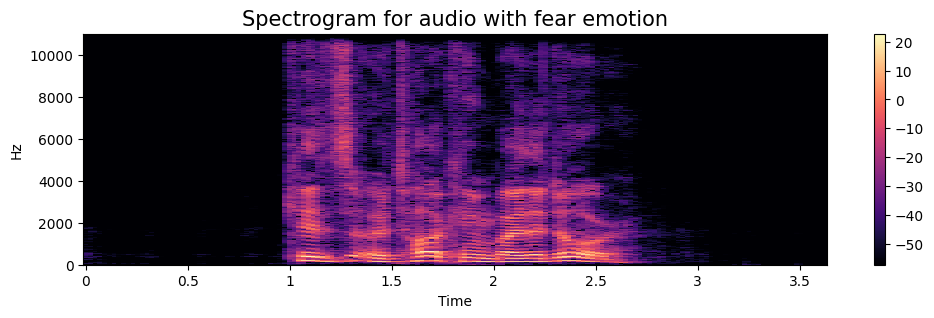

In [40]:
emotion='fear'

path = np.array(data_path["Path"][data_path["Emotions"] == emotion])[1]
data, sampling_rate = librosa.load(path)

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

Audio(path)

##### Angry

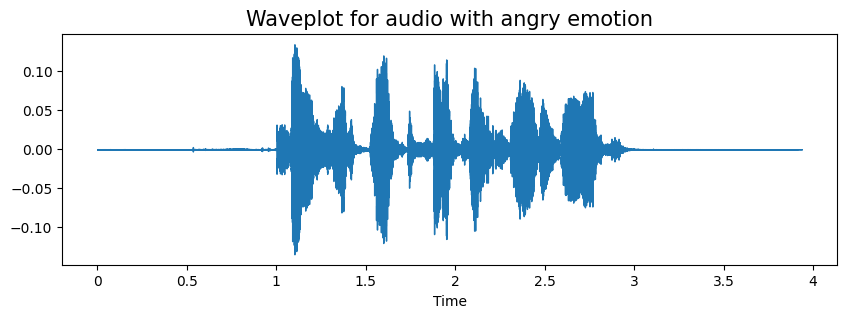

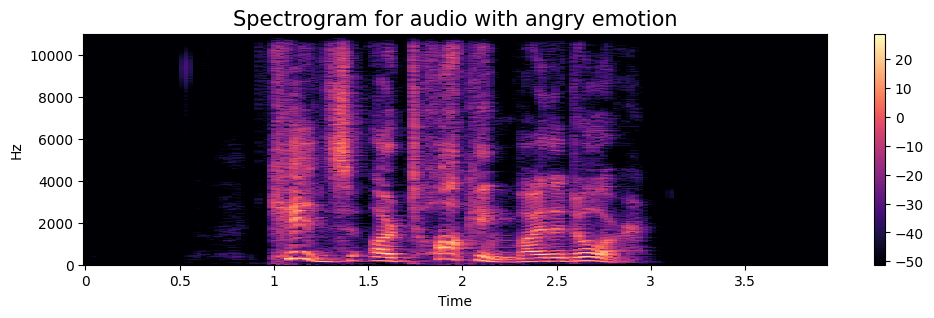

In [41]:
emotion='angry'

path = np.array(data_path["Path"][data_path["Emotions"]==emotion])[1]
data, sampling_rate = librosa.load(path)

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

Audio(path)

##### Sad

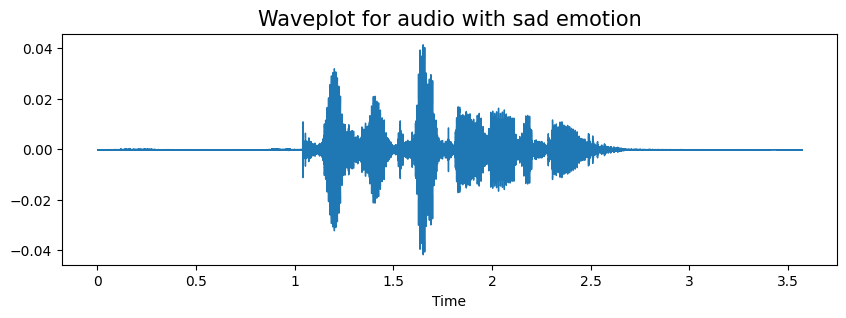

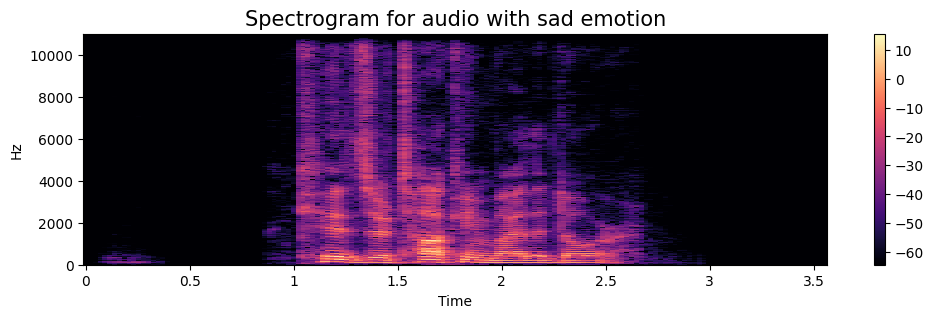

In [42]:
emotion='sad'

path = np.array(data_path["Path"][data_path["Emotions"]==emotion])[1]
data, sampling_rate = librosa.load(path)

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

Audio(path)

##### Happy

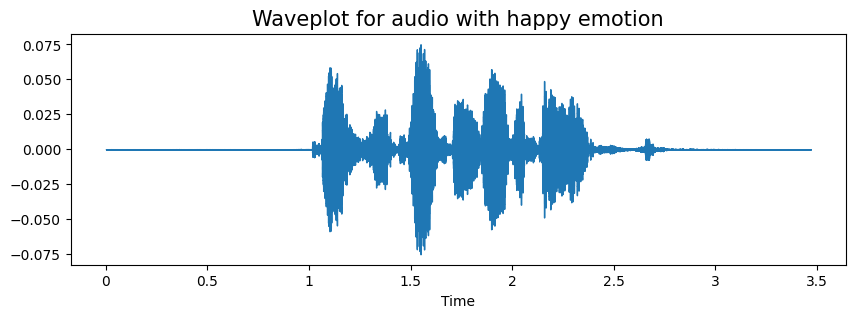

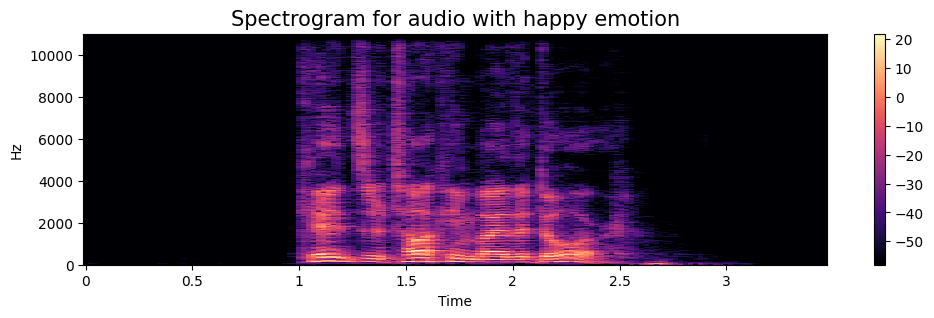

In [43]:
emotion='happy'

path = np.array(data_path["Path"][data_path["Emotions"]==emotion])[1]
data, sampling_rate = librosa.load(path)

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

Audio(path)

### Data Augmentation

We're using data augmentation to create new synthetic data samples by adding small perturbations (like noise, time shift) on our initial training dataset.

This helps in making the model invariant to the perturbations, hence enhancing its ability to generalize.

Checking various augmentation techniques to determine which works best for our dataset:

In [11]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])

    return data


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


path = np.array(data_path["Path"])[1]
data, sample_rate = librosa.load(path)

##### Simple Audio

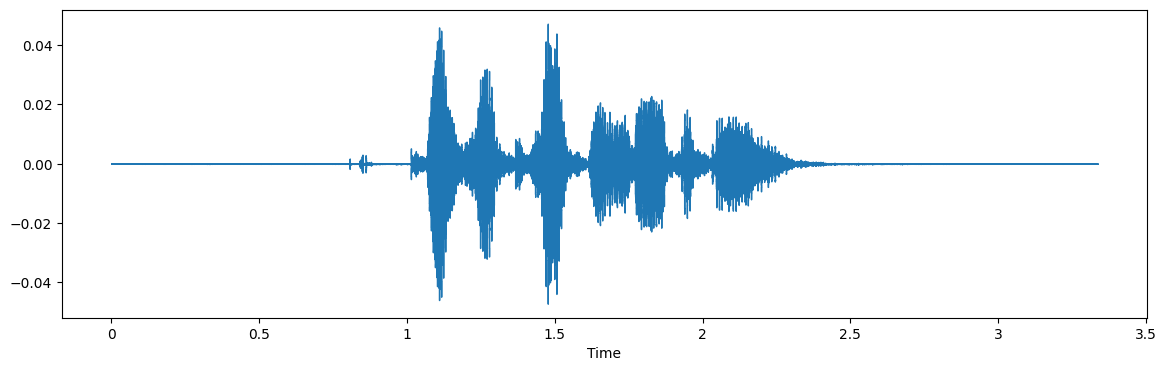

In [45]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)

Audio(path)

##### Noise Injection

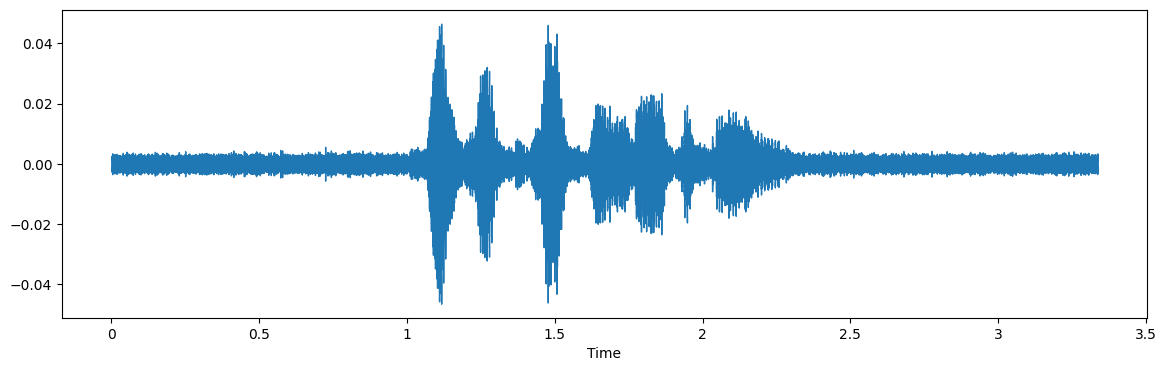

In [46]:
x = noise(data)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)

Audio(x, rate=sample_rate)

##### Stretching

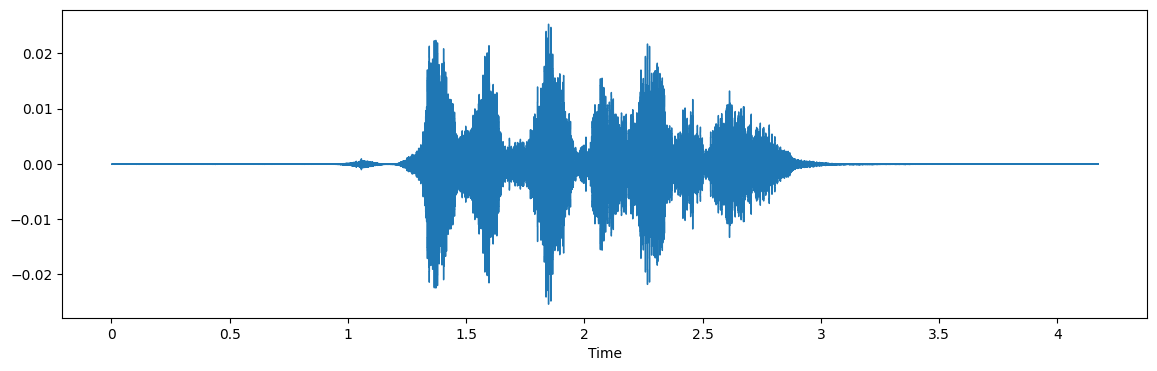

In [47]:
x = stretch(data)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)

Audio(x, rate=sample_rate)

##### Shifting

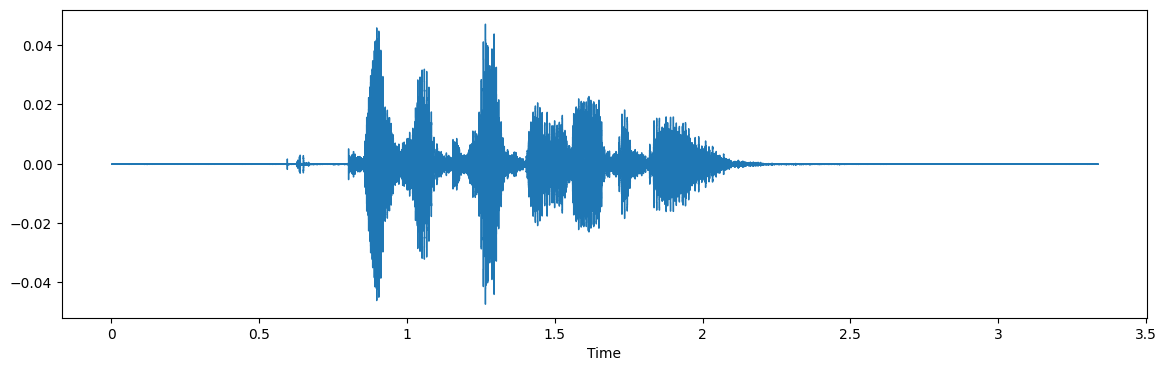

In [48]:
x = shift(data)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)

Audio(x, rate=sample_rate)

##### Pitch

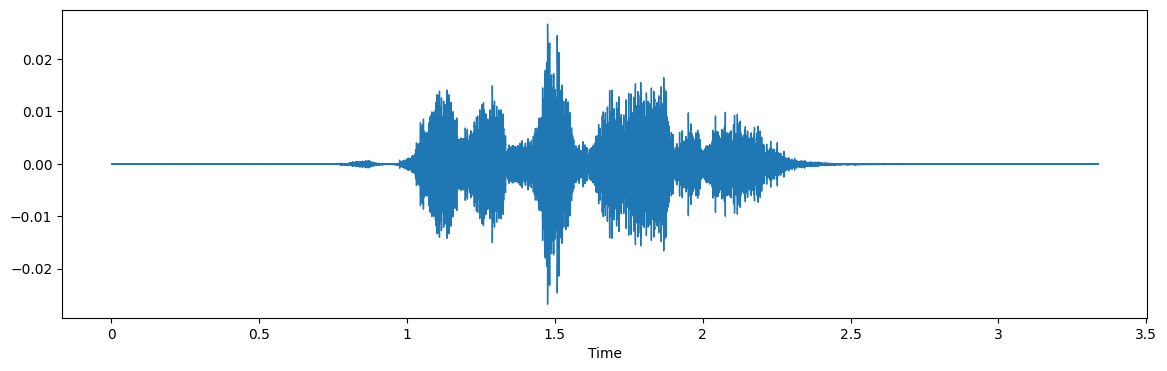

In [49]:
x = pitch(data, sample_rate)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)

Audio(x, rate=sample_rate)

From the above techniques, we'll be using noise, stretching and some pitching.

### Feature Extraction

For audio data, with the help of sampling rate and the sample data, we can perform several transformations on the data to extract the valuable features.

The various feature extraction methods being used are:
- `mel_spectrogram`: Represents the frequency content of a signal on the Mel scale, capturing timbre and pitch-related information.
- `mfcc_1 to mfcc_40`: Mel-Frequency Cepstral Coefficients, capturing how energy is distributed across different frequency bands—useful for speech analysis.
- `delta_mfcc_1 to delta_mfcc_40`: First derivative of MFCCs, capturing dynamic changes in speech over time.
- `delta2_mfcc_1 to delta2_mfcc_40`: Second derivative of MFCCs, modeling acceleration in spectral changes for better phoneme transitions.

We are using these feature extraction methods as we will be using a deep learning model for the project.

In [50]:
def extract_features(y, sr, n_mfcc=40):
    result = np.array([])

    # Mel Spectrogram:
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Converting to dB scale
    mel_spec_mean = np.mean(mel_spec_db, axis=1)  
    result = np.hstack((result, mel_spec_mean))

    # MFCCs (Mel-Frequency Cepstral Coefficients):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    result = np.hstack((result, mfccs_mean))

    # Delta (First-order derivative of MFCCs):
    delta_mfccs = librosa.feature.delta(mfccs)
    delta_mfccs_mean = np.mean(delta_mfccs, axis=1)
    result = np.hstack((result, delta_mfccs_mean))

    # Delta-Delta (Second-order derivative of MFCCs):
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    delta2_mfccs_mean = np.mean(delta2_mfccs, axis=1)
    result = np.hstack((result, delta2_mfccs_mean))
    
    return result

Generating features with augmentation:

In [51]:
def get_features(audio_path):
    y, sr = librosa.load(audio_path, duration=2.5, offset=0.6)  # y - data, sr - sampling rate

    features_ = np.vstack([
        extract_features(y, sr),
        extract_features(noise(y), sr),
        extract_features(stretch(y), sr),
        extract_features(pitch(y, sr), sr) 
    ])

    return features_

Extracting features from dataset:

In [52]:
X, Y = [], []

for path, emotion in zip(data_path["Path"], data_path["Emotions"]):
    features = get_features(path)

    for feature in features:
        X.append(feature)
        Y.append(emotion)

In [53]:
len(X), len(Y), data_path["Path"].shape

(16960, 16960, (4240,))

In [54]:
features = pd.DataFrame(X)
features["labels"] = Y

features.to_csv("features.csv", index=False, encoding="utf-8")
features.head()

0          1          2          3          4          5  \
0 -66.177673 -54.424973 -47.673393 -44.502914 -47.234108 -50.298832   
1 -50.683520 -47.471180 -39.838249 -34.749695 -36.006677 -40.133312   
2 -67.862373 -56.427032 -48.897011 -45.398476 -48.518562 -51.205624   
3 -66.856491 -55.357121 -48.117657 -43.402969 -45.041595 -48.664234   
4 -64.776154 -54.704697 -48.968460 -44.220558 -45.235886 -47.786644   

           6          7          8          9  ...       239       240  \
0 -49.839283 -48.287735 -48.026699 -48.964348  ...  0.001768  0.001449   
1 -39.283692 -37.158135 -36.860556 -36.775515  ... -0.022909 -0.007893   
2 -50.995716 -48.934326 -49.056919 -50.352966  ...  0.001777  0.001430   
3 -47.823589 -46.914982 -45.738327 -47.555161  ... -0.000331 -0.001328   
4 -49.589508 -48.547318 -46.484325 -45.880608  ...  0.001182 -0.005748   

        241       242       243       244       245       246       247  \
0  0.001168  0.000962  0.000861  0.000885  0.001036  0.001301  0.001651   
1 -0.002307 -0.018736 -0.007781  0.011542  0.022486 -0.021074 -0.008685   
2  0.001130  0.000883  0.000692  0.000558  0.000479  0.000454  0.000479   
3  0.002108 -0.001944  0.004796 -0.000486  0.003852  0.004112  0.000744   
4 -0.002027 -0.001491  0.002238 -0.003867 -0.005112 -0.001862 -0.005924   

    labels  
0  neutral  
1  neutral  
2  neutral  
3  neutral  
4  neutral  

[5 rows x 249 columns]

### Data Preparation

Now, we normalize and split our data for training and testing.

In [36]:
# features = pd.DataFrame(pd.read_csv("features.csv"))

X = features.iloc[: ,:-1].values
Y = features['labels'].values

Normalizing features:

In [37]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Using a label encoder on Y:

In [43]:
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
Y_categorical = to_categorical(Y_encoded)

['neutral' 'neutral' 'neutral' ... 'sad' 'sad' 'sad']


Splitting data into train and test:

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_encoded, random_state=42, shuffle=True, test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((13568, 248), (13568,), (3392, 248), (3392,))

Scaling the data:

In [45]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((13568, 248), (13568,), (3392, 248), (3392,))

Reshaping `x_train` and `x_test` for the CNN model as they require 2D feature maps:

In [46]:
x_train = x_train.reshape(-1, x_test.shape[1], 1, 1)
x_test = x_test.reshape(-1, x_test.shape[1], 1, 1)

num_emotion_classes = Y_categorical.shape[1]

y_train = to_categorical(y_train, num_classes=num_emotion_classes)
y_test = to_categorical(y_test, num_classes=num_emotion_classes)

print(f"New Train shape: {x_train.shape}")
print(f"New Test shape: {x_test.shape}")

New Train shape: (13568, 248, 1, 1)
New Test shape: (3392, 248, 1, 1)


### Modeling

In [47]:
def cnn_model(shape, num_classes):
    model = Sequential()

    # Convolutional Layer 1:
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=shape, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.2))

    # Convolutional Layer 2:
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.3))

    # Convolutional Layer 3:
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.4))

    # Flatten & Fully Connected Layers:
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer:
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Defining the model:

In [48]:
input_shape = (x_train.shape[1], 1, 1)
model = cnn_model(input_shape, num_emotion_classes)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 248, 1, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 248, 1, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 124, 1, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 124, 1, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 124, 1, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 124, 1, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 62, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 62, 1, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 62, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 31, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       508,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 602,632 (2.30 MB)

 Trainable params: 602,184 (2.30 MB)

 Non-trainable params: 448 (1.75 KB)

Training the model:

In [54]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitoring validation loss
    factor=0.5,          # Reducing learning rate by a factor of 0.5
    patience=5,          # Wait for 5 epochs before reducing LR
    min_lr=1e-6,         # Minimum possible learning rate
    verbose=1            # Print updates
)

history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[reduce_lr]
)

Epoch 1/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9487 - loss: 0.1404 - val_accuracy: 0.9617 - val_loss: 0.1181 - learning_rate: 1.2500e-04
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9474 - loss: 0.1461 - val_accuracy: 0.9605 - val_loss: 0.1194 - learning_rate: 1.2500e-04
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9527 - loss: 0.1345 - val_accuracy: 0.9605 - val_loss: 0.1185 - learning_rate: 1.2500e-04
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9473 - loss: 0.1497 - val_accuracy: 0.9617 - val_loss: 0.1187 - learning_rate: 1.2500e-04
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9440 - loss: 0.1484 - val_accuracy: 0.9623 - val_loss: 0.1189 - learning_rate: 1.2500e-04
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9426 - loss: 0.1508
Epoch 6: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy:

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9689 - loss: 0.1126
Accuracy of our model on test data :  96.46226167678833 %


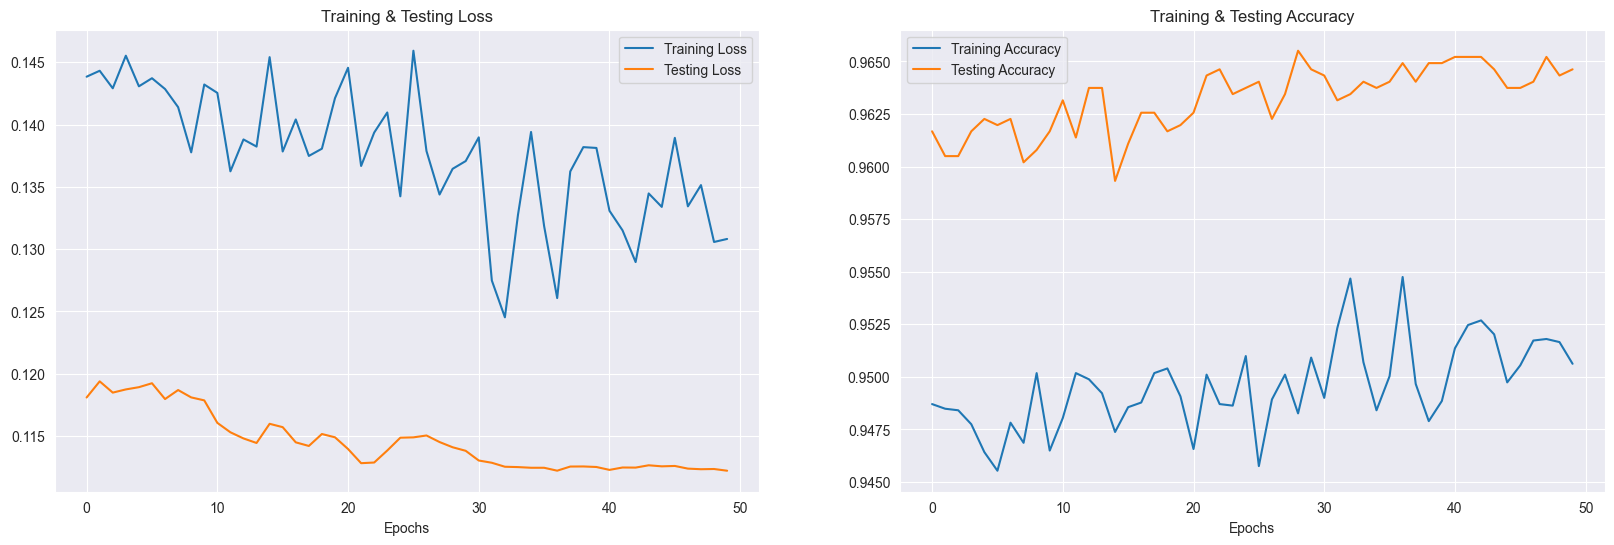

In [55]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1] * 100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()

Predicting on test data:

In [60]:
y_pred = model.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_emotions = label_encoder.inverse_transform(y_pred_labels)

y_test_labels = np.argmax(y_test, axis=1)
y_test_emotions = label_encoder.inverse_transform(y_test_labels)

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [62]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])

df['Predicted Labels'] = y_pred_emotions.flatten()
df['Actual Labels'] = y_test_emotions.flatten()

df.head(10)

Predicted Labels Actual Labels
0          disgust       disgust
1            angry         angry
2             fear          fear
3          neutral       neutral
4             fear          fear
5             calm          calm
6         surprise      surprise
7             fear          fear
8          disgust       disgust
9            happy         happy

In [64]:
print(classification_report(y_test_emotions, y_pred_emotions))

              precision    recall  f1-score   support

       angry       0.98      0.97      0.98       482
        calm       0.91      0.95      0.93       149
     disgust       0.96      0.97      0.97       476
        fear       0.99      0.96      0.97       479
       happy       0.96      0.96      0.96       491
     neutral       0.96      0.97      0.97       385
         sad       0.97      0.95      0.96       481
    surprise       0.95      0.96      0.95       449

    accuracy                           0.96      3392
   macro avg       0.96      0.96      0.96      3392
weighted avg       0.96      0.96      0.96      3392

